In [22]:
!git clone -q https://github.com/DataHow/analytics-course-scripts.git

fatal: destination path 'analytics-course-scripts' already exists and is not an empty directory.


In [23]:
#@title Import libraries
import importlib
import ipywidgets as widgets
from ipywidgets import interact,interactive,fixed
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import pandas as pd
import os
import copy
import importlib
import scipy.integrate
import scipy.stats
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"

# Script 0
# from pyDOE2 import fullfact, ff2n, ccdesign
# import definitive_screening_design as dsd

# Script 1
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.stats import chi2

# Script 2
import statsmodels.api as sm
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

process = importlib.import_module("analytics-course-scripts.interactions.modules.process_introduction")

In [24]:
#@title Functions for the script
FEED_START = (1, 4)
FEED_END = (8, 12)
FEED_RATE = (5, 20)
GLC_0 = (10, 80)
VCD_0 = (0.1, 1.0)
NUM_RUNS=50
DOE_DESIGN="Latin-Hypercube Sampling"

FEED_START_test = (1, 3)
FEED_END_test = (8, 11)
FEED_RATE_test = (10, 20)
GLC_0_test = (30, 70)
VCD_0_test = (0.5, 1.0)
NUM_RUNS_test=50
DOE_DESIGN_test="Latin-Hypercube Sampling"

TARGET_VAR_AGGR= False

doe_array = process.generate_doe(FEED_START, FEED_END, FEED_RATE, GLC_0, VCD_0, NUM_RUNS, DOE_DESIGN)
owu, doe = process.generate_data(doe_array)
owu = owu.drop(["timesteps"],axis=1)
bwu = process.generate_bwu(owu)
tar = process.generate_y(bwu, return_aggr=TARGET_VAR_AGGR)
doe_array_test = process.generate_doe(FEED_START_test, FEED_END_test, FEED_RATE_test, GLC_0_test, VCD_0_test, NUM_RUNS_test, DOE_DESIGN_test)
owu_test, doe_test = process.generate_data(doe_array_test)
owu_test = owu_test.drop(["timesteps"],axis=1)
bwu_test = process.generate_bwu(owu_test)
tar_test = process.generate_y(bwu_test, return_aggr=TARGET_VAR_AGGR)
dataset = copy.copy(doe)
dataset["Target"] = tar


def fit_linear_model_simple(doe,tar):
  # Fit Linear Model
  datascaler = StandardScaler()
  does = datascaler.fit_transform(doe.values)
  X = sm.add_constant(does)
  y = tar.values
  mod = sm.OLS(y.astype(float), X.astype(float))
  res = mod.fit()
  print(res.summary())




def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips


def fit_linear_model(doe,tar,polynomial_degree=1,interactions_only=True):

  # Define pipeline
  include_bias = False
  if polynomial_degree ==0:
    include_bias=True
  poly_features = PolynomialFeatures(degree=polynomial_degree, interaction_only=interactions_only,include_bias=include_bias)
  standard_scaler = StandardScaler(with_mean=True, with_std=True)
  lm_model = LinearRegression()
  pipe = Pipeline([('features', poly_features),
                  ('scaler', standard_scaler),
                  ('model', lm_model)])
  # Fit model
  X = doe
  y = tar
  pipe.fit(X,y)

  # Model Features and Coefficients
  X_columns = poly_features.get_feature_names_out()
  lm_coefficients = lm_model.coef_
  # Model Std Error and p-values (not via sklearn)
  X_preproc = pd.DataFrame(pipe.steps[1][1].transform(pipe.steps[0][1].transform(X)),columns=X_columns)
  ols_model = sm.OLS(y.values.astype(float), sm.add_constant(X_preproc).values.astype(float)).fit()
  ols_coefficients = ols_model.params[1:]
  if X_preproc.shape[1]<X_preproc.shape[0]:
    ols_stderror = ols_model.bse[1:]
    ols_pvalue = ols_model.pvalues[1:].round(4)
  else:
    print("\n !!! Model is overspecified !!! \n Results in perfect fit and unreliable coefficients  \n")
    ols_stderror = None
    ols_pvalue = None
  return X_columns, ols_coefficients, ols_stderror, ols_pvalue, pipe

def plot_linear_model_coef(polynomial_degree=1,interactions_only=True):
  X_columns, ols_coefficients, ols_stderror, ols_pvalue, pipe =  fit_linear_model(doe, tar, polynomial_degree=polynomial_degree,interactions_only=interactions_only)

  # Plot Model Inference
  fig = px.bar(x=list(X_columns),
               y=ols_coefficients.reshape(-1),
               title="Linear model coefficients",
               labels={'x':"Variables", 'y':"Estimated Coefficients",'color':"p-value"},
               error_y=ols_stderror,
               color=ols_pvalue)
  fig.update_layout(width=1600)
  fig.show()

def plot_linear_model_eval(polynomial_degree=1,interactions_only=True):
  X_columns, ols_coefficients, ols_stderror, ols_pvalue, pipe =  fit_linear_model(doe, tar, polynomial_degree=polynomial_degree,interactions_only=interactions_only)

  # Make predictions
  X = doe
  y = tar
  yhat = pipe.predict(doe)
  X_test = doe_test
  y_test = tar_test
  yhat_test = pipe.predict(X_test)

  # Calculate error metrics
  train_r2 = round(pipe.score(X,y),3)
  train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
  train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
  test_r2 = round(pipe.score(X_test,y_test),3)
  test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
  test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

  # Plot observed vs predicted
  fig = make_subplots(rows=1, cols=2, subplot_titles=(
      f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
      f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
  # Train set plot
  fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers"),row=1,col=1)
  fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
  # Test set plot
  fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers"),row=1,col=2)
  fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)
  fig.update_layout(width=1600)
  fig.update_xaxes(title="Observed values")
  fig.show()

def plot_linear_model_eval(polynomial_degree=1,interactions_only=True):
  X_columns, ols_coefficients, ols_stderror, ols_pvalue, pipe =  fit_linear_model(doe, tar, polynomial_degree=polynomial_degree,interactions_only=interactions_only)

  # Make predictions
  X = doe
  y = tar
  yhat = pipe.predict(doe)
  X_test = doe_test
  y_test = tar_test
  yhat_test = pipe.predict(X_test)

  # Calculate error metrics
  train_r2 = round(pipe.score(X,y),3)
  train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
  train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
  test_r2 = round(pipe.score(X_test,y_test),3)
  test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
  test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

  # Plot observed vs predicted
  fig = make_subplots(rows=1, cols=2, subplot_titles=(
      f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
      f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
  # Train set plot
  fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers",name='Train set'),row=1,col=1)
  fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
  # Test set plot
  fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers",name='Test set'),row=1,col=2)
  fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)
  fig.update_layout(width=1600)
  fig.update_xaxes(title="Observed values",row=1,col=1)
  fig.update_xaxes(title="Observed values",row=1,col=2)
  fig.update_yaxes(title="Predicted values",row=1,col=1)
  fig.update_yaxes(title="Predicted values",row=1,col=2)
  fig.show()


def fit_pls_model(doe, tar, latent_variables=5, polynomial_degree=1,interactions_only=False):
  # Define pipeline
  include_bias = False
  if polynomial_degree ==0:
    print("Constant model for pls is not allowed!")
    latent_variables=1
    include_bias=True
  if polynomial_degree ==1:
    latent_variables=min(latent_variables,5)
  poly_features = PolynomialFeatures(degree=polynomial_degree, interaction_only=interactions_only,include_bias=include_bias)
  standard_scaler = StandardScaler(with_mean=True, with_std=True)

  pls_model = PLSRegression(n_components=latent_variables,scale=True)
  pipe = Pipeline([('features', poly_features),
                  ('scaler', standard_scaler),
                  ('model', pls_model)])
  # Fit PLS model
  X = doe
  y = tar
  pipe.fit(X,y)
  # Model features and variable importance
  X_columns = poly_features.get_feature_names_out()
  X_preproc = pd.DataFrame(pipe.steps[1][1].transform(pipe.steps[0][1].transform(X)),columns=X_columns)
  pls_vip = vip(X_preproc,y,pls_model)
  return X_columns, pls_vip, pipe

def plot_pls_model_coef(latent_variables=5,polynomial_degree=1,interactions_only=True):

  X_columns, pls_vip, pipe = fit_pls_model(doe, tar, latent_variables=latent_variables, polynomial_degree=polynomial_degree,interactions_only=interactions_only)
  # Plot Model Inference
  fig = px.bar(x=list(X_columns),
              y=pls_vip.reshape(-1),
              title="VIP scores of PLS model",
              labels={'x':"Variables", 'y':"Estimated VIP",'color':"p-value"})
  fig.add_hline(y=1)
  fig.add_hline(y=0.8,line=dict(color='gray'))
  fig.update_layout(width=1600)
  fig.show()



def plot_pls_model_eval(latent_variables=5,polynomial_degree=1,interactions_only=True):
  X_columns, pls_vip, pipe = fit_pls_model(doe, tar, latent_variables=latent_variables, polynomial_degree=polynomial_degree,interactions_only=interactions_only)

  # Make predictions
  X = doe
  y = tar
  yhat = pipe.predict(doe)
  X_test = doe_test
  y_test = tar_test
  yhat_test = pipe.predict(X_test)

  # Calculate error metrics
  train_r2 = round(pipe.score(X,y),3)
  train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
  train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
  test_r2 = round(pipe.score(X_test,y_test),3)
  test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
  test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

  # Plot observed vs predicted
  fig = make_subplots(rows=1, cols=2, subplot_titles=(
      f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
      f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
  # Train set plot
  fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers"),row=1,col=1)
  fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
  # Test set plot
  fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers"),row=1,col=2)
  fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)


  fig.update_layout(width=1600)
  fig.update_xaxes(title="Observed values",row=1,col=1)
  fig.update_xaxes(title="Observed values",row=1,col=2)
  fig.update_yaxes(title="Predicted values",row=1,col=1)
  fig.update_yaxes(title="Predicted values",row=1,col=2)
  fig.show()


def fit_hist_pls_model(doe, bwu, tar, latent_variables=5,process_history=14,input_variables=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc']):
    # Create and preprocess bwu matrix
    X_bwu = bwu
    remove_columns = []
    # Remove Variables
    remove_columns.extend([c for c in bwu.columns if c.startswith('X:Titer')])
    if 'X:Lac' in input_variables:
        pass
    else:
        remove_columns.extend([c for c in bwu.columns if c.startswith('X:Lac')])
    if 'W:Feed' in input_variables:
        pass
    else:
        remove_columns.extend([c for c in bwu.columns if c.startswith('W:Feed')])
    if 'X:Glc' in input_variables:
        pass
    else:
        remove_columns.extend([c for c in bwu.columns if c.startswith('X:Glc')])
    if 'X:VCD' in input_variables:
        pass
    else:
        remove_columns.extend([c for c in bwu.columns if c.startswith('X:VCD')])
    # Remove History
    for d in range(process_history,15):
        remove_columns.extend([c for c in bwu.columns if c.endswith(':0')])
        remove_columns.extend([c for c in bwu.columns if c.endswith(":"+str(d))])
    # Remove Invariant
    remove_columns.extend(list(bwu.columns[~(bwu != bwu.iloc[0]).any().values]))
    # Add and remove columns
    X_preproc = pd.concat([doe, X_bwu.drop(set(remove_columns),axis=1)], axis=1)

    # Define Pipeline
    pscaler = StandardScaler(with_mean=True,with_std=True)
    pls_bwu = PLSRegression(n_components=latent_variables)
    pipe = Pipeline([('scaler', pscaler), ('pls', pls_bwu)])
    # Train PLS model
    y = tar
    X = X_preproc
    X_columns = X.columns
    pipe.fit(X,y)
    pls_bwu_vip = vip(X,y,pls_bwu)
    return X_columns, X_preproc, remove_columns, pls_bwu_vip, pls_bwu, pipe


def plot_hist_pls_eval(latent_variables=5,process_history=14,input_variables=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc']):
    X_columns, X_preproc, remove_columns, pls_bwu_vip,pls_bwu, pipe = fit_hist_pls_model(doe, bwu,tar,latent_variables=latent_variables,process_history=process_history,input_variables=input_variables)
    # Train PLS model
    y = tar
    X = X_preproc
    X_columns = X.columns
    pipe.fit(X,y)

    # Make predictions
    yhat = pipe.predict(X)
    X_test = pd.concat([doe_test, bwu_test.drop(set(remove_columns),axis=1)], axis=1)
    y_test = tar_test
    yhat_test = pipe.predict(X_test)

    # Calculate error metrics
    train_r2 = round(pipe.score(X,y),3)
    train_abs_rmse = round(mean_squared_error(y, yhat,squared=False),3)
    train_rel_rmse = round(mean_squared_error(y, yhat,squared=False) / np.std(np.array(y)),3)
    test_r2 = round(pipe.score(X_test,y_test),3)
    test_abs_rmse = round(mean_squared_error(y_test, yhat_test,squared=False),3)
    test_rel_rmse = round(mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test)),3)

    # Plot observed vs predicted
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
        f"Train Set <br> R^2 = {train_r2} <br> Abs RMSE = {train_abs_rmse} <br> Rel RMSE = {train_rel_rmse}" ,
        f"Test Set <br> R^2 = {test_r2} <br> Abs RMSE = {test_abs_rmse} <br> Rel RMSE = {test_rel_rmse}"))
    # Train set plot
    fig.add_trace(go.Scatter(x=y.values.reshape(-1),y=yhat.reshape(-1),mode="markers"),row=1,col=1)
    fig.add_shape(type="line",x0=min(yhat)[0],y0=min(yhat)[0],x1=max(yhat)[0],y1=max(yhat)[0], layer='below', line=dict(dash='dash'))
    # Test set plot
    fig.add_trace(go.Scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1),mode="markers"),row=1,col=2)
    fig.add_shape(type="line",x0=min(yhat_test)[0],y0=min(yhat_test)[0],x1=max(yhat_test)[0],y1=max(yhat_test)[0], layer='below', line=dict(dash='dash'),row=1,col=2)
    fig.update_layout(title_text = "Observed vs Predicted",showlegend=False)
    fig.update_layout(width=1600)
    fig.show()

def plot_hist_pls_coef(latent_variables=5,process_history=14,input_variables=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc']):
    X_columns, X_preproc, remove_columns, pls_bwu_vip, pls_bwu, pipe = fit_hist_pls_model(doe, bwu,tar,latent_variables=latent_variables,process_history=process_history,input_variables=input_variables)
    fig = px.bar(x=list(X_columns),
             y=pls_bwu_vip.reshape(-1),
             title="VIP scores of PLS model",
             labels={'x':"Variables", 'y':"Estimated VIP",'color':"p-value"})
    fig.add_hline(y=1)
    fig.add_hline(y=0.8,line=dict(color='gray'))
    fig.update_layout(width=1600)
    fig.show()

def plot_hist_pls_scores(pc_x_axis=1, pc_y_axis=2,latent_variables=5,process_history=14,input_variables=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc']):
    X_columns, X_preproc, remove_columns, pls_bwu_vip, pls_bwu, pipe = fit_hist_pls_model(doe, bwu,tar,latent_variables=latent_variables,process_history=process_history,input_variables=input_variables)
    fig = make_subplots(rows=2, cols=2, specs=[[{"colspan": 2}, None],[{}, {}]],subplot_titles=("Scores Plot ","Loadings of Principal Component - "+str(pc_x_axis),"Loadings of Principal Component - "+str(pc_y_axis)),vertical_spacing=0.1)
    fig.add_trace(go.Scatter(x=pls_bwu.x_scores_[:,pc_x_axis],y=pls_bwu.x_scores_[:,pc_y_axis],mode='markers',name='Scores'),row=1,col=1)
    fig.add_bar(x=X_columns, y=pls_bwu.x_loadings_[:,pc_x_axis-1], name='Loadings PC - ' + str(pc_x_axis),row=2, col=[1,2])
    fig.add_bar(x=X_columns, y=pls_bwu.x_loadings_[:,pc_y_axis-1], name='Loadings PC - ' + str(pc_y_axis),row=2, col=2)
    fig.update_layout(height=900,width=1600)
    fig.show()


def plot_hist_pls_hyperparameters(latent_variables=5,process_history=14,input_variables=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc']):
    X_columns, X_preproc, remove_columns, pls_bwu_vip, pls_bwu, pipe = fit_hist_pls_model(doe, bwu,tar,latent_variables=latent_variables,process_history=process_history,input_variables=input_variables)
    y = tar
    X = X_preproc
    range_LV = range(1, X.shape[1]-1)
    train_eval, valid_eval = validation_curve(pipe, X, y, param_name = "pls__n_components", param_range=list(range_LV),scoring = 'neg_root_mean_squared_error')
    train_score=-np.mean(train_eval,axis=1)
    valid_score=-np.mean(valid_eval,axis=1)
    train_std = np.std(train_eval,axis=1)
    valid_std = np.std(valid_eval,axis=1)
    fig = go.Figure()
    fig.add_trace(go.Scatter( x=list(range_LV), y=train_score, error_y=dict(type='data',array=train_std,visible=True), name="Training"))
    fig.add_trace(go.Scatter( x=list(range_LV), y=valid_score, error_y=dict(type='data',array=valid_std,visible=True), name="Validation"))
    fig.update_layout(title="Hyperparameter Optimization in PLS",xaxis_title="Number of Latent Variables",yaxis_title="RMSE",legend_title="Evaluation type")
    fig.update_layout(width=1600)
    fig.show()




In [38]:
#@title Widgets definition


POLYNOMIAL_DEGREE = widgets.IntSlider(
    value=1,
    min=0,
    max=4,
    step=1,
    description='polynomial_degree',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style= {'description_width': 'initial'},
)

POLYNOMIAL_DEGREE_PLS = widgets.IntSlider(
    value=1,
    min=1,
    max=4,
    step=1,
    description='polynomial_degree',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style= {'description_width': 'initial'},
)

INTERACTIONS_ONLY = widgets.Checkbox(
    value=False,
    description='interactions_only',
    disabled=False,
    indent=False,
    style= {'description_width': 'initial'},
)

LATENT_VARIABLES = widgets.IntSlider(
    value=1,
    min=1,
    max=15,
    step=1,
    description='latent_variables',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style= {'description_width': 'initial'},
)

LATENT_VARIABLES_HIST = widgets.IntSlider(
    value=5,
    min=1,
    max=15,
    step=1,
    description='latent_variables',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style= {'description_width': 'initial'},
)

INPUT_VARIABLES = widgets.SelectMultiple(
    options=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc', 'X:Lac','W:Feed'],
    value=['feed_start','feed_end','feed_rate','glc_0','vcd_0','X:VCD', 'X:Glc'],
    rows=9,
    description='input_variables',
    disabled=False,
    style= {'description_width': 'initial'},
)

PROCESS_HISTORY = widgets.IntSlider(
    value=14,
    min=1,
    max=14,
    step=1,
    description='process_history',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style= {'description_width': 'initial'},
)


# Initial Conditions Models

From OWU train and test dataset we create BWU data, DOE data and Target data.
DOE data contains the initial parameter conditions (or Z variable) for the experiments.
Target data contain just the final values of Titer at day 14.

In [26]:
dataset.head(10)

,feed_start,feed_end,feed_rate,glc_0,vcd_0,Target
0,2.500000,10.000000,12.500000,45.000000,0.550000,1555.956929
1,2.867347,11.224490,10.663265,70.714286,0.568367,1491.563604
2,3.418367,9.265306,8.520408,63.571429,0.329592,1346.520212
3,3.602041,10.571429,18.928571,59.285714,0.182653,1121.576491
4,3.112245,8.204082,5.459184,62.142857,0.770408,876.049852
5,2.071429,10.653061,13.724490,36.428571,0.678571,1580.058841
6,1.520408,11.061224,5.153061,12.142857,0.384694,356.448447
7,3.663265,10.326531,19.846939,45.000000,0.862245,1569.426011
8,2.622449,8.530612,19.540816,69.285714,0.586735,909.624282
9,3.969388,11.551020,14.948980,13.571429,0.733673,1004.07159


## Multiple Linear Regression

We first train/fit a Linear Regression model to the final titer, using the data loaded above.

We then characterize the performance of the model using ANOVA, where the user can have information about the importance of each coefficient and of the overall model.

### Create linear model with preprocessing

Here we create a linear model to predict the value of the final titer given the initial conditions.

* Input matrix: "doe". This corresponds to the values of the manipulated process parameters for each experiment.
* Output target: "tar". This corresponds to the final value of titer at the end of each experiment. (or aggregates)

In [27]:
fit_linear_model_simple(doe, tar)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     2.129
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0796
Time:                        13:16:35   Log-Likelihood:                -360.01
No. Observations:                  50   AIC:                             732.0
Df Residuals:                      44   BIC:                             743.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1171.5510     48.870     23.973      0.0

Where the description/interpretation of some items in the table is as follows:
* R-squared : the coefficient of determination. It is the proportion of the variance in the dependent variable that is predictable/explained
* Adj. R-squared : Adjusted R-squared is the modified form of R-squared adjusted for the number of independent variables in the model. Value of adj. R-squared increases, when we include extra variables which actually improve the model.
* F-statistic : the ratio of mean squared error of the model to the mean squared error of residuals. It determines the overall significance of the model.
* coef : the coefficients of the independent variables and the constant term in the equation.
* t : the value of t-statistic. It is the ratio of the difference between the estimated and hypothesized value of a parameter, to the standard error

### Model Training and Inference

In this section, we fit a different linear model that is more flexible regarding the inputs. We mainly check the predictions of the models versus the training data for the final titer.


In [28]:
interactive(plot_linear_model_coef, polynomial_degree=POLYNOMIAL_DEGREE, interactions_only=INTERACTIONS_ONLY)

interactive(children=(IntSlider(value=1, continuous_update=False, description='polynomial_degree', max=4, styl…

In [29]:
interactive(plot_linear_model_eval, polynomial_degree=POLYNOMIAL_DEGREE, interactions_only=INTERACTIONS_ONLY)

interactive(children=(IntSlider(value=1, continuous_update=False, description='polynomial_degree', max=4, styl…

## Model Comparison
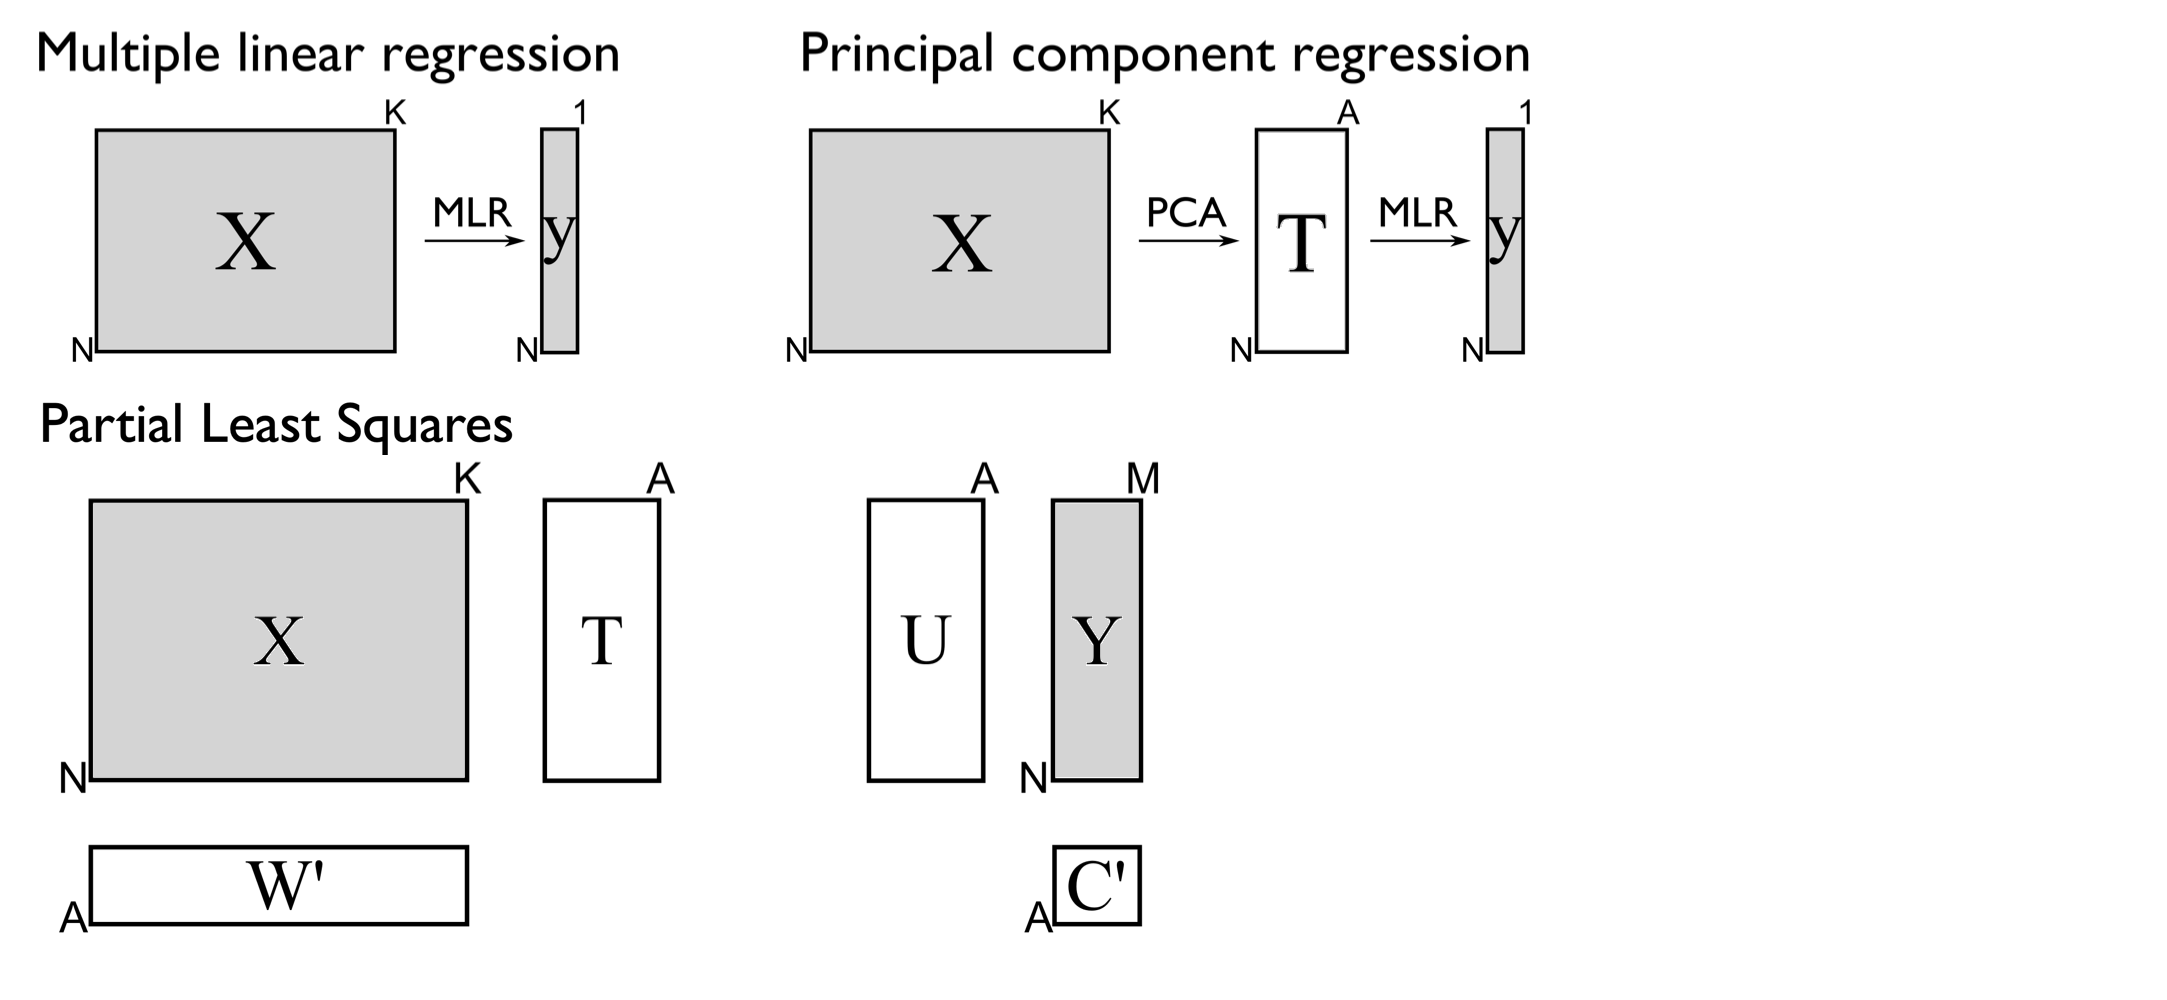

## PLS Model

In this section, we keep the same data structure but we train a PLS model. PLS model allows us to use more variables/columns without the model being overspecified.

In a case of single response $y$ and $k$ predictors, PLS regression model with $h$ latent variables is expressed as follows.

$ X = T W^t + E$

$ y = U c^t +f$

The VIP score is a summary of the importance for the projections to find $h$ latent variables. It's calculated for $j-th$ variable as
$ VIP_j = (k \sum_i^h (SS(c_i t_i)(w_{ij} / ||{w_i}||)^2) / \sum_k^h(c_i t_i))^{1/2}$
Since the average of squared VIP scores equals 1, 'greather than one rule' is generally used as criterion for variable selection.

### Create a PLS model with specific latent variables

Create a PLS model to predict the value of the final titer given the initial conditions.

* Input matrix: "doe". This corresponds to the values of the manipulated process parameters for each experiment.
* Output target: "tar". This corresponds to the final value of titer at the end of each experiment. (or aggregates)

Select the number of latent variables for the model (the maximum number of latent variables is 5, equal to the number of variables in the input matrix).

In [30]:
interactive(plot_pls_model_coef, latent_variables=LATENT_VARIABLES, polynomial_degree=POLYNOMIAL_DEGREE_PLS, interactions_only=INTERACTIONS_ONLY)

interactive(children=(IntSlider(value=1, continuous_update=False, description='latent_variables', max=15, min=…

In [31]:
interactive(plot_pls_model_eval, latent_variables=LATENT_VARIABLES, polynomial_degree=POLYNOMIAL_DEGREE_PLS, interactions_only=INTERACTIONS_ONLY)

interactive(children=(IntSlider(value=1, continuous_update=False, description='latent_variables', max=15, min=…

# Historical Model

In an so-called historical model, the data from different experiments are ordered into a batch-wise unfolded (BWU) matrix (i.e., every row corresponds to an experiment).

The BWU can be used to compute final properties of the experiment, like CQAs, which are typically the effect of the cumulated effect of the experiment profile.

In this example, we will use the BWU matrix to predict the final value of titer. Clearly, titer information are removed from the BWU matrix.



## Multiple Linear Model

Unlinke in the initial conditions model, there are several problems in using an linear regression / response surface model for modelling historical data. The main problem is that MLR requires our dataset $X$ (the BWU data) to have more rows (samples) than columns (variables). Second is that if $X^T X$ has full rank due only to noise, the inverse is unstable and small changes in noise realization can produce dramatically different results.

If we look at the shape of our BWU matrix, that it already has 75 variables and only 50 samples which makes it dificult to fit linear model.

In [32]:
bwu.shape

(50, 75)

## Historical PLS Model

We demonstrate that with more information and more variables, the PLS becomes a model with good predictions and low RMSEP.

### Create BWU matrix

Here the BWU matrix is created. The vaues of the manipulated variables are added as columns at the beginning of the matrix. The following pre-processing was performed.

* Remove titer (and also lactate)
* Remove exceeding days
* Eliminate invariant columns
* Remove linearly dependent columns
* Add process parameters at the beginning
* Create a PLS model from the initial design to the final titer


In [33]:
bwu.head(10)

,X:VCD:0,X:VCD:1,X:VCD:2,X:VCD:3,X:VCD:4,X:VCD:5,X:VCD:6,X:VCD:7,X:VCD:8,X:VCD:9,...,W:Feed:5,W:Feed:6,W:Feed:7,W:Feed:8,W:Feed:9,W:Feed:10,W:Feed:11,W:Feed:12,W:Feed:13,W:Feed:14
0,0.550000,1.725244,4.779558,10.281522,15.843605,18.448543,17.949288,15.678095,12.817300,10.043513,...,12.500000,12.500000,12.500000,12.500000,12.500000,0.000000,0.00000,0.0,0.0,0.0
1,0.568367,1.793107,4.930412,10.361098,15.551357,17.758413,17.147579,14.979682,12.288500,9.670987,...,10.663265,10.663265,10.663265,10.663265,10.663265,10.663265,0.00000,0.0,0.0,0.0
2,0.329592,1.053354,3.096302,7.485146,13.251367,17.202666,18.019565,16.535826,13.975592,11.208375,...,8.520408,8.520408,8.520408,8.520408,0.000000,0.000000,0.00000,0.0,0.0,0.0
3,0.182653,0.588124,1.804815,4.873490,10.231183,15.492414,17.609985,16.507446,13.591358,9.979932,...,18.928571,18.928571,18.928571,18.928571,18.928571,18.928571,0.00000,0.0,0.0,0.0
4,0.770408,2.401201,6.320825,12.328713,17.281182,18.886851,17.611873,14.765839,10.506942,6.727690,...,5.459184,5.459184,5.459184,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0
5,0.678571,2.101967,5.626106,11.445434,16.731443,18.793432,17.865034,15.363724,12.427675,9.667612,...,13.724490,13.724490,13.724490,13.724490,13.724490,13.724490,0.00000,0.0,0.0,0.0
6,0.384694,1.140615,3.093566,7.013105,11.984622,13.245077,9.923159,7.247944,5.365012,4.211203,...,5.153061,5.153061,5.153061,5.153061,5.153061,5.153061,0.00000,0.0,0.0,0.0
7,0.862245,2.660245,6.869218,13.021940,17.658725,18.761966,17.274575,14.594316,11.684205,9.001846,...,19.846939,19.846939,19.846939,19.846939,19.846939,0.000000,0.00000,0.0,0.0,0.0
8,0.586735,1.848924,5.064710,10.574531,15.569108,16.790820,14.607358,10.787764,6.866206,3.913500,...,19.540816,19.540816,19.540816,19.540816,0.000000,0.000000,0.00000,0.0,0.0,0.0
9,0.733673,2.154126,5.417392,9.854514,8.481650,9.515242,10.449104,10.511079,9.836732,8.713580,...,14.948980,14.948980,14.948980,14.948980,14.948980,14.948980,14.94898,0.0,0.0,0.0


In [34]:
interactive(plot_hist_pls_coef,latent_variables=LATENT_VARIABLES_HIST, process_history=PROCESS_HISTORY, input_variables=INPUT_VARIABLES)

interactive(children=(IntSlider(value=5, continuous_update=False, description='latent_variables', max=15, min=…

In [35]:
interactive(plot_hist_pls_eval, latent_variables=LATENT_VARIABLES_HIST, process_history=PROCESS_HISTORY, input_variables=INPUT_VARIABLES)

interactive(children=(IntSlider(value=5, continuous_update=False, description='latent_variables', max=15, min=…

In [36]:
interactive(plot_hist_pls_scores,pc_x_axis=(1,4),pc_y_axis=(1,4),latent_variables=LATENT_VARIABLES_HIST, process_history=PROCESS_HISTORY, input_variables=INPUT_VARIABLES)

interactive(children=(IntSlider(value=1, description='pc_x_axis', max=4, min=1), IntSlider(value=2, descriptio…

### Hyperparameter Optimization in Cross Validation


In this section, we will simulate a typical cross- validation to define the optimal number of latent variables.


Nfold PLS models are trained using (Nfolds-1) folds. For each model, the sum of squared residuals (SSR) is calculated and summed up..

This is repeated for different numbers of latent variables. The number of latent variables returning the least value of the RMSE is chosen as optimal.
A second criterion is selected, namely the adjusted R-squared (adj. R^2), which is weighting the effect of the number of latent variables, i.e., if two values of the number of latent variables are returning a similar value of the SSR, then the one using less variables is chosen to be more likely to produce robust predictions.:


In [37]:
plot_hist_pls_hyperparameters()